### 1. Data collection

In [ ]:
import requests
import pandas as pd
import time
import os

In [ ]:
# Fetch posts
def fetch_so_nlp_raw(pagesize=100, max_pages=300):
    os.makedirs('data', exist_ok=True)
    base_url = 'https://api.stackexchange.com/2.3/questions'
    params = {
        'order': 'desc',
        'sort': 'votes',
        'tagged': 'nlp',
        'site': 'stackoverflow',
        'pagesize': pagesize,
        'filter': 'withbody',
        'key': 'rl_rQSEsFvV3UNXeonUxCYTzNbEW'
    }
    headers = {
        'User-Agent': 'Mozilla/5.0 (Assignment2 Data Collection)'
    }
    all_items = []
    # fetch data for each page
    for page in range(1, max_pages + 1):
        print(f'Fetching page {page}...')
        params['page'] = page
        response = requests.get(base_url, params=params, headers=headers)
        # Too many requests
        if response.status_code == 429:
            print('Too many requests. Sleeping for 20 seconds...')
            time.sleep(20)
            continue
        # Request failed
        if response.status_code != 200:
            print(f'Request failed on page {page} with status code: {response.status_code}')
            break
        # Failed to parse JSON
        try:
            data = response.json()
        except Exception as e:
            print(f'Failed to parse JSON on page {page}: {e}')
            time.sleep(10)
            continue
        # Respect backoff policy
        backoff = data.get('backoff', None)
        if backoff:
            print(f'Server requested backoff. Sleeping for {backoff} seconds...')
            time.sleep(backoff)
        # Extract and store relevant fields
        items = data.get('items', [])
        if not items:
            print('No more items. Ending early.')
            break
        for item in items:
            all_items.append({
                'question_id': item.get('question_id', ''),
                'title': item.get('title', ''),
                'body': item.get('body', ''),
                'tags': str(item.get('tags', [])),
                'creation_date': item.get('creation_date', ''),
                'view_count': item.get('view_count', ''),
                'accepted_answer_id': item.get('accepted_answer_id', '')
            })
        if page % 10 == 0:
            df_temp = pd.DataFrame(all_items)
            df_temp.drop_duplicates(subset='question_id', inplace=True)
            df_temp.to_csv('data/so_raw_posts.csv', index=False)
            print(f'Saved snapshot after page {page}, total collected: {len(df_temp)}')
        time.sleep(3) 
    # Save the collected data
    df = pd.DataFrame(all_items)
    df.drop_duplicates(subset='question_id', inplace=True)
    df.to_csv('data/so_raw_posts.csv', index=False)
    print(f'Finished! Total posts fetched: {len(df)}')
    print('Raw post data saved to: data/so_raw_posts.csv')
fetch_so_nlp_raw()

Fetching page 1...
Fetching page 2...
Fetching page 3...
Fetching page 4...
Fetching page 5...
Fetching page 6...
Fetching page 7...
Fetching page 8...
Fetching page 9...
Fetching page 10...
Saved snapshot after page 10, total collected: 994
Fetching page 11...
Fetching page 12...
Fetching page 13...
Fetching page 14...
Fetching page 15...
Fetching page 16...
Fetching page 17...
Fetching page 18...
Fetching page 19...
Fetching page 20...
Saved snapshot after page 20, total collected: 1991
Fetching page 21...
Fetching page 22...
Fetching page 23...
Fetching page 24...
Fetching page 25...
Fetching page 26...
Fetching page 27...
Fetching page 28...
Fetching page 29...
Fetching page 30...
Saved snapshot after page 30, total collected: 2988
Fetching page 31...
Fetching page 32...
Fetching page 33...
Fetching page 34...
Fetching page 35...
Fetching page 36...
Fetching page 37...
Fetching page 38...
Fetching page 39...
Fetching page 40...
Saved snapshot after page 40, total collected: 3984
Fe

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

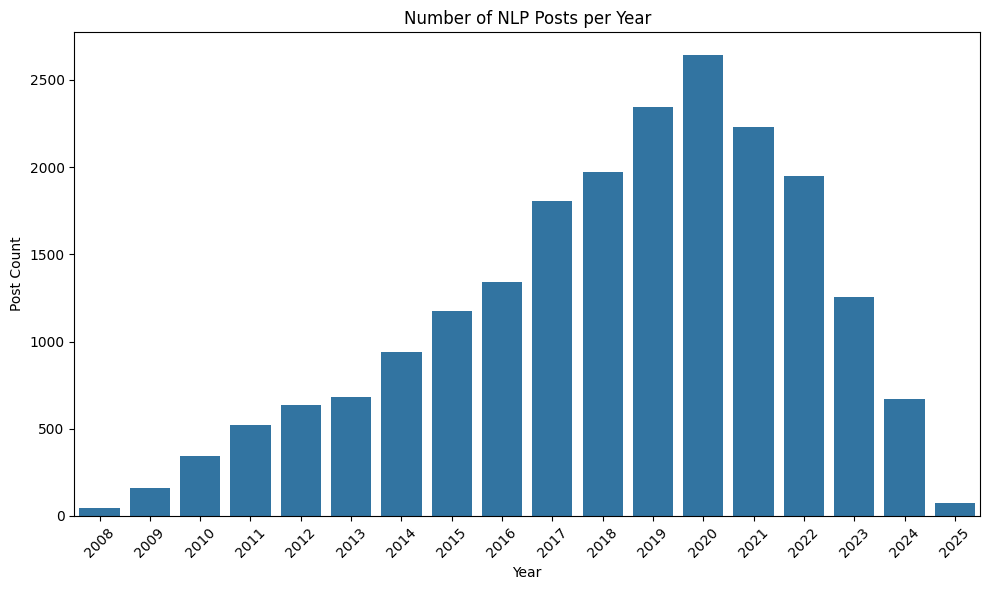

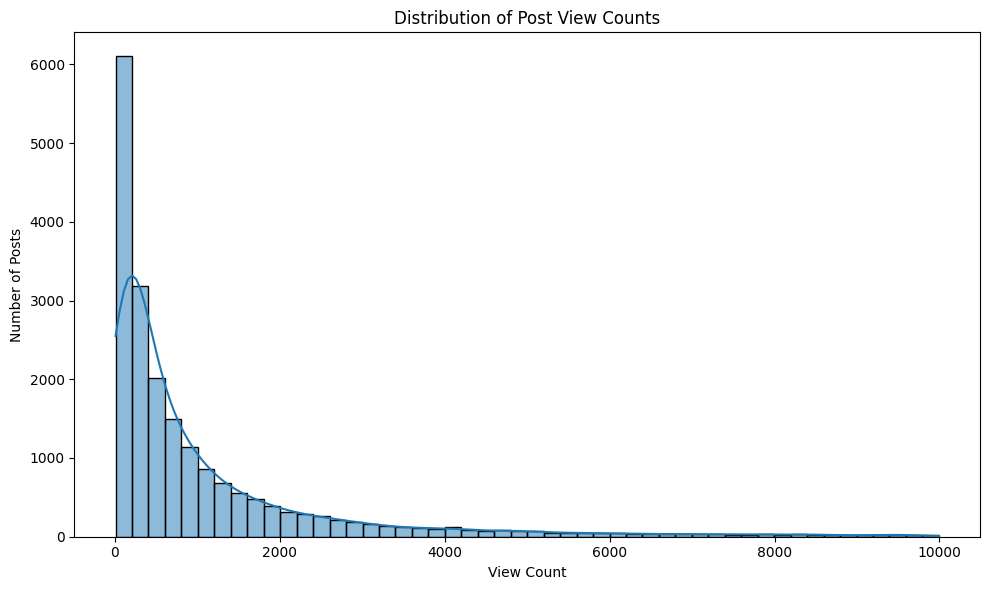

In [ ]:
# Load all data
df = pd.read_csv('data/so_raw_posts.csv')
# Convert timestamp to datetime
df['creation_date'] = pd.to_datetime(df['creation_date'], unit='s', errors='coerce')
# NLP Posts by Year
df['year'] = df['creation_date'].dt.year
# Visualization
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='year')
plt.title("Number of NLP Posts per Year")
plt.xlabel("Year")
plt.ylabel("Post Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("output/posts_per_year.png")
plt.show()
# Count Distribution
df_filtered = df[df['view_count'] <= 10000]
plt.figure(figsize=(10, 6))
sns.histplot(df_filtered['view_count'], bins=50, kde=True)
plt.title("Distribution of Post View Counts")
plt.xlabel("View Count")
plt.ylabel("Number of Posts")
plt.tight_layout()
plt.savefig("output/view_count_distribution_filtered.png")
plt.show()

In [ ]:
# Filter data with accepted answers
def get_accepted_answer_text(answer_id):
    if pd.isna(answer_id) or str(answer_id).strip() == '':
        return ''
    url = f'https://api.stackexchange.com/2.3/answers/{int(answer_id)}'
    params = {
        'site': 'stackoverflow',
        'filter': 'withbody',
        'key': 'rl_rQSEsFvV3UNXeonUxCYTzNbEW'
    }
    headers = {
        'User-Agent': 'Mozilla/5.0 (Assignment2 Data Collection)'
    }
    # fetch and parse accepted answer
    try:
        response = requests.get(url, params=params, headers=headers)
        if response.status_code == 429:
            print('429 Too Many Requests - sleeping for 20 seconds...')
            time.sleep(20)
            return get_accepted_answer_text(answer_id)
        data = response.json()
        items = data.get('items', [])
        if items:
            return items[0].get('body', '')
    except:
        return ''
    return ''
# Generate structured dataset
def generate_dataset_from_raw():
    os.makedirs('data', exist_ok=True)
    df = pd.read_csv('data/so_raw_posts.csv')
    print(f'Loaded {len(df)} raw posts')
    print('Fetching accepted answers (this may take a while)...')
    df['accepted_answer'] = df['accepted_answer_id'].apply(get_accepted_answer_text)
    df = df[df['accepted_answer'].str.strip() != '']
    # Format final output columns
    df_final = df[['title', 'body', 'tags', 'accepted_answer']]
    df_final.columns = ['title', 'description', 'tags', 'accepted_answer']
    # Save structured dataset
    df_final.to_csv('data/raw_data.csv', index=False)
    print(f'Dataset generation complete. Total rows: {len(df_final)}')
    print('Final structured dataset saved to: data/raw_data.csv')
generate_dataset_from_raw()


Loaded 20785 raw posts
Fetching accepted answers (this may take a while)...
429 Too Many Requests - sleeping for 20 seconds...
429 Too Many Requests - sleeping for 20 seconds...
429 Too Many Requests - sleeping for 20 seconds...
429 Too Many Requests - sleeping for 20 seconds...
429 Too Many Requests - sleeping for 20 seconds...
429 Too Many Requests - sleeping for 20 seconds...
429 Too Many Requests - sleeping for 20 seconds...
429 Too Many Requests - sleeping for 20 seconds...
429 Too Many Requests - sleeping for 20 seconds...
429 Too Many Requests - sleeping for 20 seconds...
429 Too Many Requests - sleeping for 20 seconds...
429 Too Many Requests - sleeping for 20 seconds...
429 Too Many Requests - sleeping for 20 seconds...
429 Too Many Requests - sleeping for 20 seconds...
429 Too Many Requests - sleeping for 20 seconds...
Dataset generation complete. Total rows: 8661
Final structured dataset saved to: data/raw_data.csv


### 2. Pre-processing

In [ ]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
import os

In [7]:
# nltk.download('punkt')
# nltk.download('stopwords')
# Load the filtered dataset with accepted answers
df = pd.read_csv('data/raw_data.csv')
# Define text cleaning function
def clean_text(text):
    if pd.isna(text):
        return ''
    text = str(text).lower()  # lowercase
    text = re.sub(r'<.*?>', ' ', text)  # remove HTML tags
    text = text.translate(str.maketrans('', '', string.punctuation))  # remove punctuation
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)  # remove non-alphabetic characters
    tokens = word_tokenize(text)  # tokenisation
    tokens = [word for word in tokens if word not in stopwords.words('english')]  # remove stopwords
    return ' '.join(tokens)
df['clean_title'] = df['title'].apply(clean_text)
df['clean_description'] = df['description'].apply(clean_text)
df['clean_answer'] = df['accepted_answer'].apply(clean_text)
# Save cleaned dataset
os.makedirs('data', exist_ok=True)
df_cleaned = df[['clean_title', 'clean_description', 'tags', 'clean_answer']]
df_cleaned.to_csv('data/clean_data.csv', index=False)
print(f'Cleaned dataset saved to data/clean_data.csv with {len(df_cleaned)} rows.')

Cleaned dataset saved to data/clean_data.csv with 8661 rows.


### 3. Graphical representation of the dataset

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

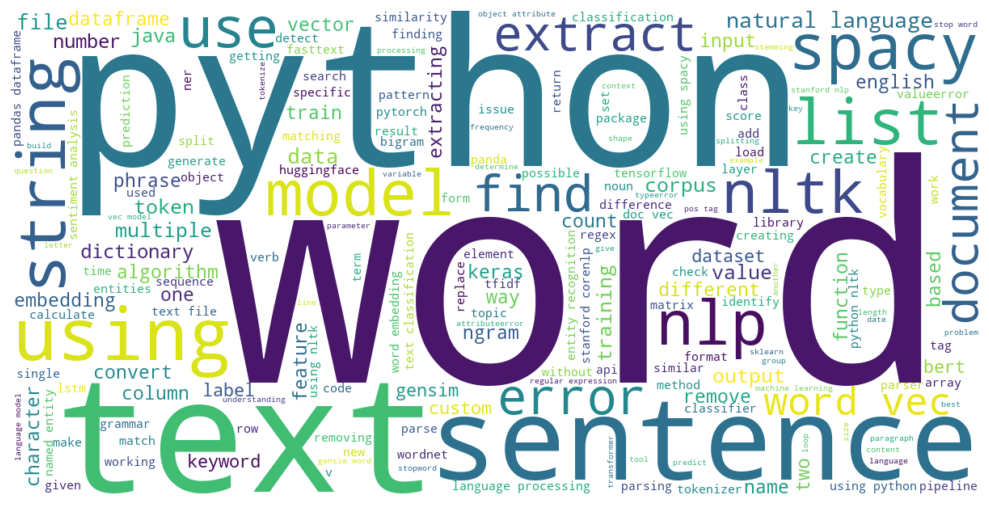

In [9]:
# Load data
df = pd.read_csv('data/clean_data.csv')
# Combine all clean titles for WordCloud
text = ' '.join(df['clean_title'].dropna().tolist())
# Generate WordCloud
wordcloud = WordCloud(width=1200, height=600, background_color='white', max_words=200).generate(text)
# Create output folder
os.makedirs('output', exist_ok=True)
# Visualization
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout()
plt.savefig('output/title_wordcloud.png')
plt.show()

### 4. Categorisation of the posts:

#### 4.1 rule-base + bert + logistic regression model

In [ ]:
import json

In [ ]:
import pandas as pd
import numpy as np
from transformers import BertTokenizer, BertModel
import torch
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import os
from tqdm import tqdm

# load clean data
df = pd.read_csv("data/clean_data.csv")

##use rule-based classification to label the first 300 posts
def rule_based_classify(row):
    text = str(row['clean_title']) + ' ' + str(row['clean_description'])
    if any(kw in text for kw in ['how to', 'how do', 'how can', 'can i', 'use', 'install', 'run', 'implement', 'fix', 'error']):
        return 'Implementation Issues'
    elif any(kw in text for kw in ['tokenizer', 'tokenize', 'split', 'segmentation']):
        return 'Tokenization Tasks'
    elif any(kw in text for kw in ['similarity', 'compare', 'match', 'distance']):
        return 'Text Similarity'
    elif any(kw in text for kw in ['stemming', 'lemmatization', 'lemmatizer', 'stemmer']):
        return 'Stemming / Lemmatization'
    elif any(kw in text for kw in ['classification', 'classify', 'predict label', 'sentiment analysis', 'text classifier']):
        return 'Text Classification'
    elif any(kw in text for kw in ['nltk', 'spacy', 'transformers', 'huggingface', 'gensim', 'word2vec', 'lda']):
        return 'NLP Libraries'
    elif any(kw in text for kw in ['what is', 'what are', 'difference between', 'meaning of']):
        return 'Conceptual Questions'
    else:
        return 'Others'

df['category'] = None
df.loc[:299, 'category'] = df.loc[:299].apply(rule_based_classify, axis=1)

#Separate labeled and unlabeled data
df_train = df[df['category'].notna()].copy()
df_unlabelled = df[df['category'].isna()].copy()

df_train['text'] = df_train['clean_title'].fillna('') + " " + df_train['clean_description'].fillna('')
df_unlabelled['text'] = df_unlabelled['clean_title'].fillna('') + " " + df_unlabelled['clean_description'].fillna('')

#encode text using BERT
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = BertModel.from_pretrained("bert-base-uncased")
bert_model.eval()

def get_bert_embedding(texts):
    embeddings = []
    with torch.no_grad():
        for text in tqdm(texts, desc="BERT Encoding"):
            inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
            outputs = bert_model(**inputs)
            cls_embedding = outputs.last_hidden_state[0][0].numpy()
            embeddings.append(cls_embedding)
    return np.array(embeddings)

X_train = get_bert_embedding(df_train['text'].tolist())
X_test = get_bert_embedding(df_unlabelled['text'].tolist())

y_train = df_train['category'].values

#train logistic regression model
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

#predict
y_pred = clf.predict(X_test)
df_unlabelled['category'] = y_pred

df_final = pd.concat([df_train, df_unlabelled], ignore_index=True)
os.makedirs("output", exist_ok=True)
df_final.to_csv("output/final_categorised_posts.csv", index=False)


BERT Encoding: 100%|██████████| 8361/8361 [18:08<00:00,  7.68it/s]


Category Counts:
category
Implementation Issues       7089
Others                      1139
NLP Libraries                223
Tokenization Tasks           167
Text Similarity               21
Stemming / Lemmatization      13
Text Classification            9
Name: count, dtype: int64


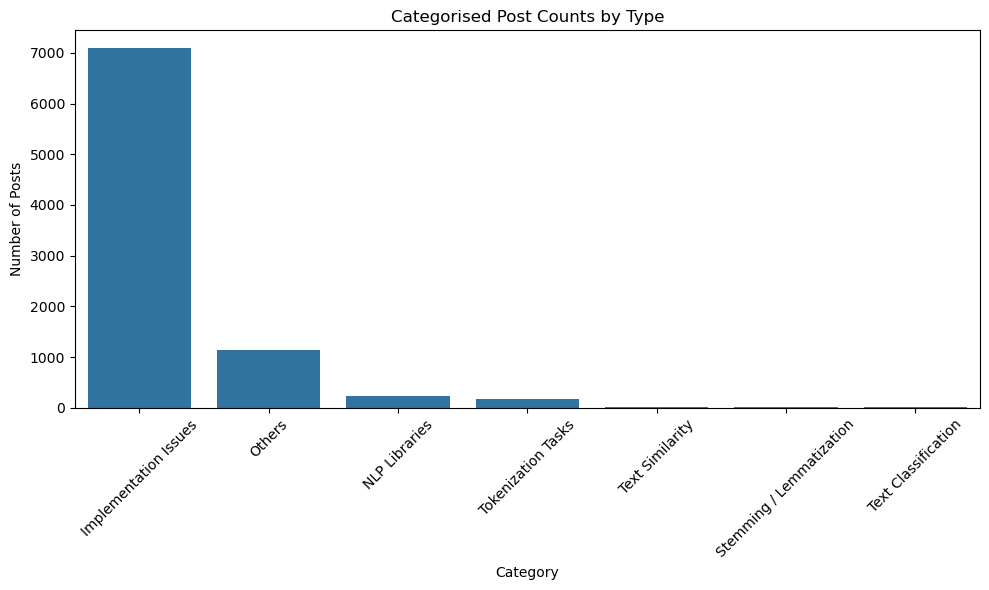

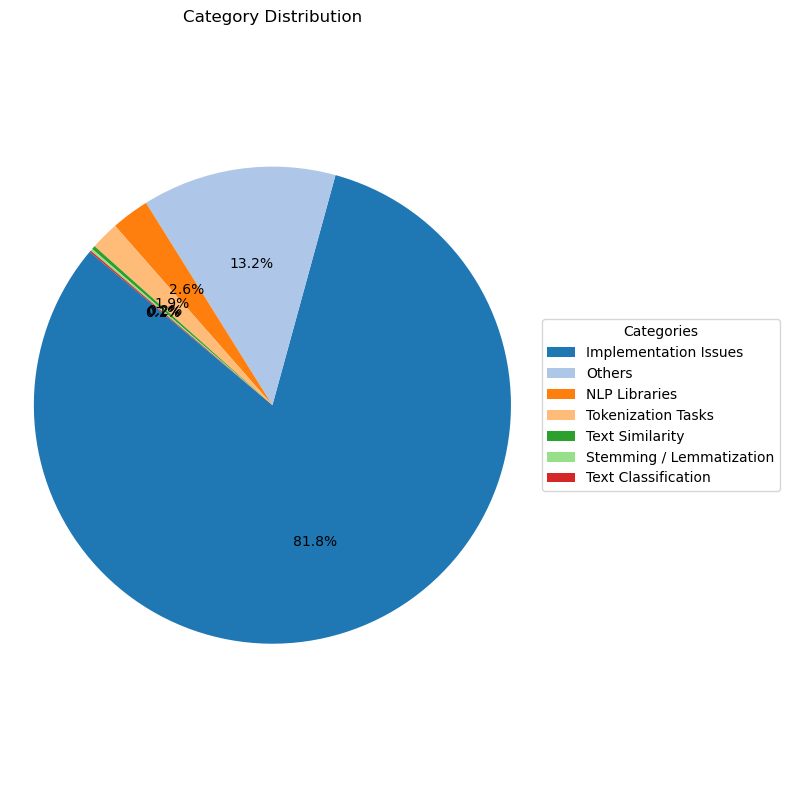


Example Titles by Category with index:

Category: Implementation Issues
- Index: 0
Title: google quotdid meanquot algorithm work
Description: ive developing internal website portfolio management tool lot text data company names etc ive really...
- Index: 2
Title: googletrans stopped working error nonetype object attribute group
Description: trying googletrans working quite well since morning started getting error went multiple posts stacko...
- Index: 3
Title: difference lemmatization vs stemming
Description: use alsois nltk lemmatization dependent upon parts speech wouldnt accurate...
- Index: 6
Title: spacy find model encorewebsm windows python anaconda custom bit
Description: difference spacyloadencorewebsm spacyloaden link explains different model sizes still clear spacyloa...
- Index: 7
Title: tfnnembeddinglookup function
Description: tfnnembeddinglookupparams ids partitionstrategymod namenone understand duty function like lookup tab...

Category: Others
- Index: 4
Title: determi

In [ ]:
##Visualisation
print("Category Counts:")
category_counts = df_final['category'].value_counts()
print(category_counts)

plt.figure(figsize=(10, 6))
sns.countplot(data=df_final, x='category', order=category_counts.index)
plt.title("Categorised Post Counts by Type")
plt.xlabel("Category")
plt.ylabel("Number of Posts")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("output/category_barplot1.png")
plt.show()

#pie
plt.figure(figsize=(8, 8))
colors = plt.cm.tab20.colors 
patches, texts, autotexts = plt.pie(
    category_counts,
    labels=None,             
    autopct='%1.1f%%',
    startangle=140,
    colors=colors
)

plt.legend(
    patches,
    category_counts.index,
    title="Categories",
    loc="center left",
    bbox_to_anchor=(1, 0.5)
)
plt.title("Category Distribution")
plt.axis('equal')  
plt.tight_layout()
plt.savefig("output/category_pie_chart1.png")
plt.show()

print("\nExample Titles by Category with index:")
examples_dict = {}
for cat in category_counts.index:
    print(f"\nCategory: {cat}")
    sample_rows = df[df['category'] == cat][['clean_title', 'clean_description']].head(5)
    examples_dict[cat] = []
    for idx, row in sample_rows.iterrows():
        print(f"- Index: {idx}")
        print(f"Title: {row['clean_title']}")
        print(f"Description: {row['clean_description'][:100]}...")
        examples_dict[cat].append({
            "index": int(idx),
            "title": row['clean_title'],
            "description": row['clean_description']
        })

#### 4.2 rule-based classification model

Category Counts:
category
Implementation Issues       5556
Others                      1498
Tokenization Tasks           589
NLP Libraries                417
Text Similarity              382
Text Classification          153
Stemming / Lemmatization      66
Name: count, dtype: int64


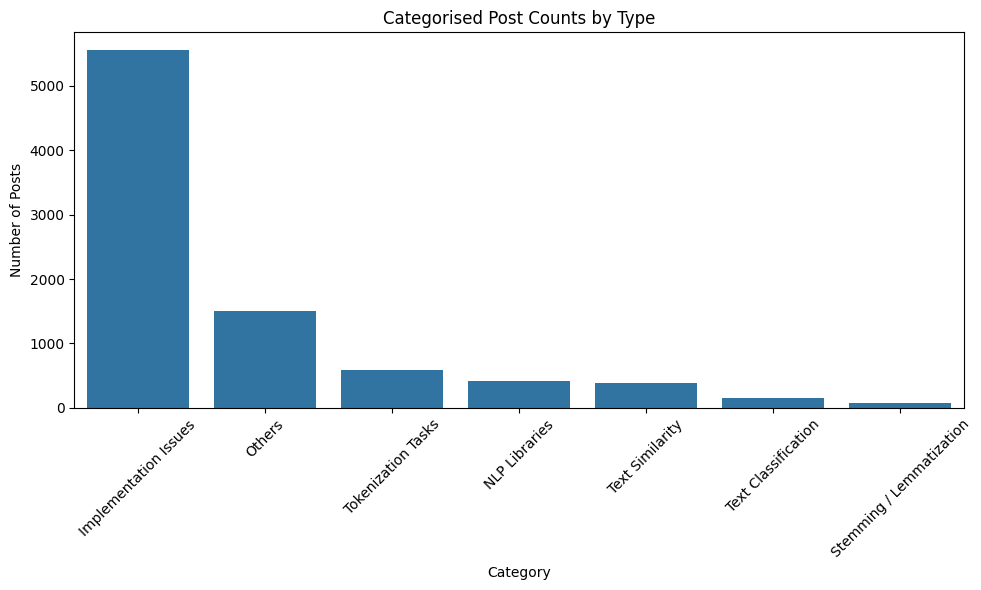

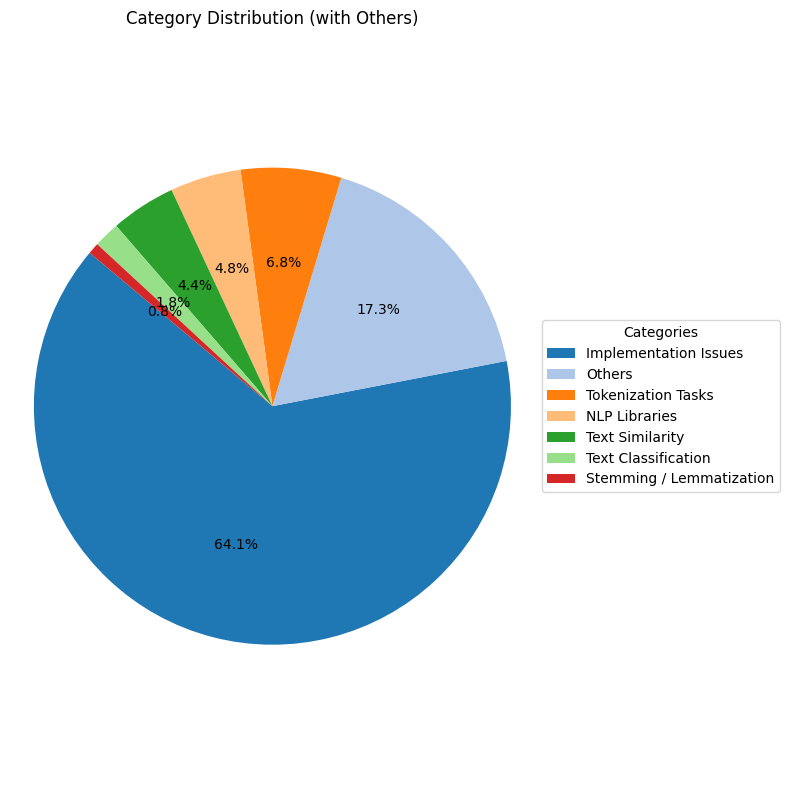


Example Titles by Category with index:

Category: Implementation Issues
- Index: 0
Title: google quotdid meanquot algorithm work
Description: ive developing internal website portfolio management tool lot text data company names etc ive really...
- Index: 2
Title: googletrans stopped working error nonetype object attribute group
Description: trying googletrans working quite well since morning started getting error went multiple posts stacko...
- Index: 3
Title: difference lemmatization vs stemming
Description: use alsois nltk lemmatization dependent upon parts speech wouldnt accurate...
- Index: 6
Title: spacy find model encorewebsm windows python anaconda custom bit
Description: difference spacyloadencorewebsm spacyloaden link explains different model sizes still clear spacyloa...
- Index: 7
Title: tfnnembeddinglookup function
Description: tfnnembeddinglookupparams ids partitionstrategymod namenone understand duty function like lookup tab...

Category: Others
- Index: 4
Title: determi

In [6]:
import json

#load the cleaned dataset
df = pd.read_csv("data/clean_data.csv")

#define rule-based function
def classify_post(row):
    title = str(row['clean_title'])
    desc = str(row['clean_description'])
    text = title + " " + desc

    if any(kw in text for kw in ['how to', 'how do', 'how can', 'can i', 'use', 'install', 'run', 'implement', 'fix', 'error']):
        return 'Implementation Issues'
    elif any(kw in text for kw in ['tokenizer', 'tokenize', 'split', 'segmentation']):
        return 'Tokenization Tasks'
    elif any(kw in text for kw in ['similarity', 'compare', 'match', 'distance']):
        return 'Text Similarity'
    elif any(kw in text for kw in ['stemming', 'lemmatization', 'lemmatizer', 'stemmer']):
        return 'Stemming / Lemmatization'
    elif any(kw in text for kw in ['classification', 'classify', 'predict label', 'sentiment analysis', 'text classifier']):
        return 'Text Classification'
    elif any(kw in text for kw in ['nltk', 'spacy', 'transformers', 'huggingface', 'gensim', 'word2vec', 'lda']):
        return 'NLP Libraries'
    elif any(kw in text for kw in ['what is', 'what are', 'difference between', 'meaning of']):
        return 'Conceptual Questions'
    else:
        return 'Others'

df['category'] = df.apply(classify_post, axis=1)

#Category counts
print("Category Counts:")
category_counts = df['category'].value_counts()
print(category_counts)

#bar chart
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='category', order=category_counts.index)
plt.title("Categorised Post Counts by Type")
plt.xlabel("Category")
plt.ylabel("Number of Posts")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("output/category_barplot2.png")
plt.show()

#pie
plt.figure(figsize=(8, 8))
colors = plt.cm.tab20.colors
patches, texts, autotexts = plt.pie(
    category_counts,
    labels=None,
    autopct='%1.1f%%',
    startangle=140,
    colors=colors
)
plt.legend(
    patches,
    category_counts.index,
    title="Categories",
    loc="center left",
    bbox_to_anchor=(1, 0.5)
)
plt.title("Category Distribution (with Others)")
plt.axis('equal')
plt.tight_layout()
plt.savefig("output/category_pie_chart2.png")
plt.show()

print("\nExample Titles by Category with index:")
examples_dict = {}
for cat in category_counts.index:
    print(f"\nCategory: {cat}")
    sample_rows = df[df['category'] == cat][['clean_title', 'clean_description']].head(5)
    examples_dict[cat] = []
    for idx, row in sample_rows.iterrows():
        print(f"- Index: {idx}")
        print(f"Title: {row['clean_title']}")
        print(f"Description: {row['clean_description'][:100]}...")
        examples_dict[cat].append({
            "index": int(idx),
            "title": row['clean_title'],
            "description": row['clean_description']
        })

df.to_csv("output/auto_categorised_posts.csv", index=True)

### 5. Compare the two model

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

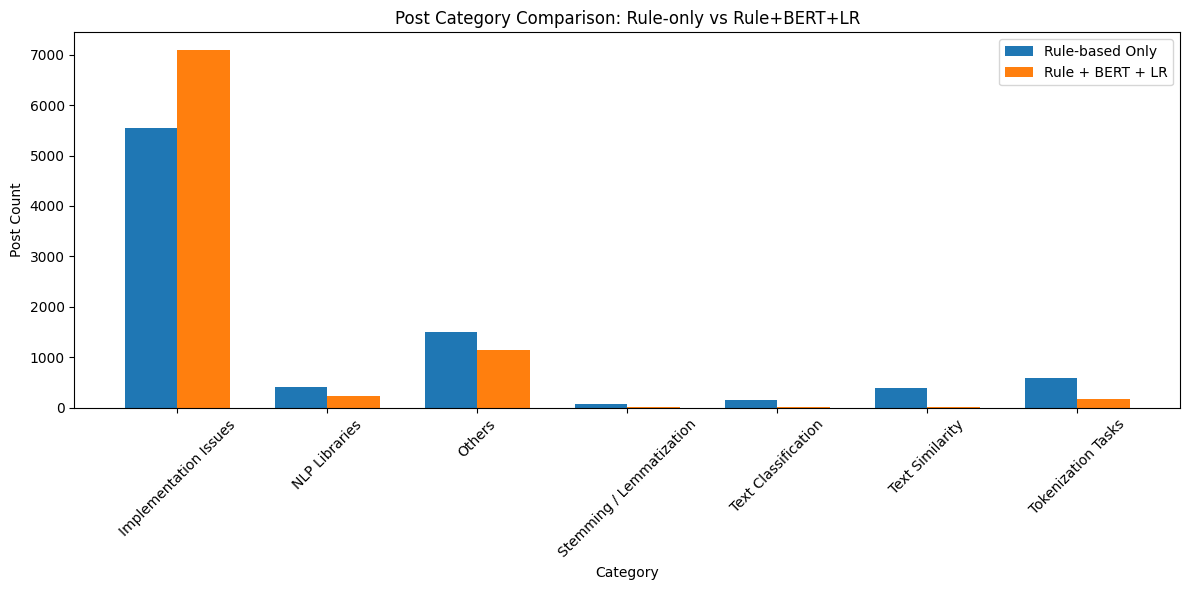

In [8]:
#load data
df_auto = pd.read_csv("output/auto_categorised_posts.csv")     # rule-based
df_bert = pd.read_csv("output/final_categorised_posts.csv")    # rule-based + bert + lr
#count the number of each category
auto_counts = df_auto['category'].value_counts()
bert_counts = df_bert['category'].value_counts()

all_categories = sorted(set(auto_counts.index).union(set(bert_counts.index)))

comparison_df = pd.DataFrame({
    'Category': all_categories,
    'Rule-based Only': [auto_counts.get(cat, 0) for cat in all_categories],
    'Rule + BERT + lr': [bert_counts.get(cat, 0) for cat in all_categories]
})

#grouped bar chart
plt.figure(figsize=(12, 6))
bar_width = 0.35
x = range(len(comparison_df))

plt.bar(x, comparison_df['Rule-based Only'], width=bar_width, label='Rule-based Only')
plt.bar([i + bar_width for i in x], comparison_df['Rule + BERT + lr'], width=bar_width, label='Rule + BERT + LR')

plt.xlabel("Category")
plt.ylabel("Post Count")
plt.title("Post Category Comparison: Rule-only vs Rule+BERT+LR")
plt.xticks([i + bar_width / 2 for i in x], comparison_df['Category'], rotation=45)
plt.legend()
plt.tight_layout()
plt.savefig("output/category_comparison_barplot.png")
plt.show()
